# Game Clustering - Engagement and Popularity Patterns

## Objective
Cluster games by engagement and popularity patterns using K-Means clustering.

**Question**: Are there distinct types of games based on how players engage with them?

## Features Used
- `price` - Game price (USD)
- `average_playtime_forever` - Average playtime across all players (stored in minutes, displayed in hours)
- `median_playtime_forever` - Median playtime across all players (stored in minutes, displayed in hours)
- `num_reviews_total` - Total number of reviews
- `peak_ccu` - Peak concurrent users

## Preprocessing Steps
1. Remove free games (price = 0)
2. Remove games with zero engagement (average_playtime_forever = 0)
3. Log scale heavy features (num_reviews_total, peak_ccu, playtime features)
4. Standardize features
5. Apply K-Means clustering (3-4 clusters)

## Dataset
- **Input:** `archive1/train_ml_ready.parquet` (combine train + test for clustering)
- **Output:** Clustered games with cluster assignments


In [45]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [46]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log10, when, mean
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Initialize Spark Session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GameClustering") \
    .getOrCreate()

# Set log level to reduce output noise
spark.sparkContext.setLogLevel("WARN")

print("Spark session created")


Spark session created


## Step 1: Load Data


In [47]:
# Load train and test datasets, then combine for clustering
train_df = spark.read.parquet("archive1/train_ml_ready.parquet")
test_df = spark.read.parquet("archive1/test_ml_ready.parquet")

# Combine train and test for clustering (we want all games)
df = train_df.union(test_df)

print(f"Total games: {df.count():,}")
print(f"Total columns: {len(df.columns)}")


Total games: 11,889
Total columns: 25


## Step 2: Select and Prepare Features


In [48]:
# Select only the features we need for clustering
features_to_use = [
    'price',
    'average_playtime_forever',
    'median_playtime_forever',
    'num_reviews_total',
    'peak_ccu'
]

print(f"Features to use: {features_to_use}")

# Select relevant columns
df_features = df.select(['appid', 'name'] + features_to_use)

# Show sample
print("\nSample data:")
df_features.show(5, truncate=False)


Features to use: ['price', 'average_playtime_forever', 'median_playtime_forever', 'num_reviews_total', 'peak_ccu']

Sample data:
+-----+----------------------------+-----+------------------------+-----------------------+-----------------+--------+
|appid|name                        |price|average_playtime_forever|median_playtime_forever|num_reviews_total|peak_ccu|
+-----+----------------------------+-----+------------------------+-----------------------+-----------------+--------+
|20   |Team Fortress Classic       |4.99 |241                     |15                     |6482             |46      |
|240  |Counter-Strike: Source      |9.99 |5044                    |255                    |124438           |14426   |
|320  |Half-Life 2: Deathmatch     |0.0  |1272                    |33                     |9455             |195     |
|360  |Half-Life Deathmatch: Source|9.99 |360                     |19                     |3822             |55      |
|440  |Team Fortress 2             |0.

## Step 3: Remove Free Games and Zero Engagement


In [49]:
# Remove free games (price = 0 or null)
df_paid = df_features.filter(
    (col("price").isNotNull()) & 
    (col("price") > 0)
)

total_games = df_features.count()
paid_games = df_paid.count()
free_games = total_games - paid_games

print(f"Total games: {total_games:,}")
print(f"Free games removed: {free_games:,}")
print(f"Paid games remaining: {paid_games:,} ({paid_games/total_games*100:.1f}%)")

# Remove games with zero engagement (no playtime)
# Games with high reviews but 0 playtime don't make sense for engagement clustering
df_with_engagement = df_paid.filter(
    (col("average_playtime_forever").isNotNull()) &
    (col("average_playtime_forever") > 0)
)

zero_engagement_games = paid_games - df_with_engagement.count()

print(f"Paid games before: {paid_games:,}")
print(f"Games with zero engagement removed: {zero_engagement_games:,}")
print(f"Games with engagement remaining: {df_with_engagement.count():,} ({df_with_engagement.count()/paid_games*100:.1f}%)")

# Update df_paid to use the filtered version
df_paid = df_with_engagement


Total games: 11,889
Free games removed: 2,429
Paid games remaining: 9,460 (79.6%)
Paid games before: 9,460
Games with zero engagement removed: 4,926
Games with engagement remaining: 4,534 (47.9%)


## Step 4: Handle Missing Values and Apply Log Scaling

In [50]:
# Fill null values with 0 for numerical features
for feature in features_to_use:
    df_paid = df_paid.withColumn(
        feature,
        when(col(feature).isNull(), 0).otherwise(col(feature))
    )

# Apply log scaling to heavy features (add 1 to avoid log(0))
# Log scale: num_reviews_total, peak_ccu, average_playtime_forever, median_playtime_forever
df_scaled = df_paid.withColumn(
    "log_num_reviews_total",
    log10(col("num_reviews_total") + 1)
).withColumn(
    "log_peak_ccu",
    log10(col("peak_ccu") + 1)
).withColumn(
    "log_avg_playtime",
    log10(col("average_playtime_forever") + 1)
).withColumn(
    "log_median_playtime",
    log10(col("median_playtime_forever") + 1)
)

# Final features for clustering (price + log-scaled features)
clustering_features = [
    'price',
    'log_avg_playtime',
    'log_median_playtime',
    'log_num_reviews_total',
    'log_peak_ccu'
]

print(f"Features for clustering: {clustering_features}")

# Show sample
print("\nSample after log scaling:")
df_scaled.select(['appid', 'name'] + clustering_features).show(5, truncate=False)


Features for clustering: ['price', 'log_avg_playtime', 'log_median_playtime', 'log_num_reviews_total', 'log_peak_ccu']

Sample after log scaling:
+-----+----------------------------+-----+------------------+-------------------+---------------------+------------------+
|appid|name                        |price|log_avg_playtime  |log_median_playtime|log_num_reviews_total|log_peak_ccu      |
+-----+----------------------------+-----+------------------+-------------------+---------------------+------------------+
|20   |Team Fortress Classic       |4.99 |2.383815365980431 |1.2041199826559248 |3.811776021602904    |1.6720978579357175|
|240  |Counter-Strike: Source      |9.99 |3.7028611705729295|2.4082399653118496 |5.094956512431628    |4.15917603179347  |
|360  |Half-Life Deathmatch: Source|9.99 |2.5575072019056577|1.3010299956639813 |3.582404298019028    |1.7481880270062005|
|2280 |DOOM + DOOM II              |9.99 |2.1818435879447726|1.5440680443502757 |4.318522442141257    |2.37106786227

## Step 5: Standardize Features


In [51]:
# Create feature vector
assembler = VectorAssembler(
    inputCols=clustering_features,
    outputCol="features",
    handleInvalid="skip"
)

# Standardize features (mean=0, std=1)
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

# Apply transformations
df_assembled = assembler.transform(df_scaled)
scaler_model = scaler.fit(df_assembled)
df_final = scaler_model.transform(df_assembled)

print(f"Final dataset size: {df_final.count():,} games")
print("\nSample with scaled features:")
df_final.select(['appid', 'name', 'scaled_features']).show(3, truncate=False)


Final dataset size: 4,534 games

Sample with scaled features:
+-----+----------------------------+----------------------------------------------------------------------------------------------------+
|appid|name                        |scaled_features                                                                                     |
+-----+----------------------------+----------------------------------------------------------------------------------------------------+
|20   |Team Fortress Classic       |[-0.870398963426551,-0.14793093083212153,-1.9636383072905477,0.7370236740088323,0.40394319280584595]|
|240  |Counter-Strike: Source      |[-0.4897486672723811,1.8393992915680255,-0.039934463067914434,2.74560154909962,2.9455824807662494]  |
|360  |Half-Life Deathmatch: Source|[-0.4897486672723811,0.1137605386502519,-1.8088147288660257,0.3779853528569346,0.4817026155573682]  |
+-----+----------------------------+--------------------------------------------------------------------------

## Step 6: Determine Optimal Number of Clusters


k=2: WSSSE = 13988.88
k=3: WSSSE = 11226.49
k=4: WSSSE = 9747.39
k=5: WSSSE = 8455.87
k=6: WSSSE = 7437.20
k=7: WSSSE = 6867.76
k=8: WSSSE = 6444.94
k=9: WSSSE = 6026.31
k=10: WSSSE = 5779.29


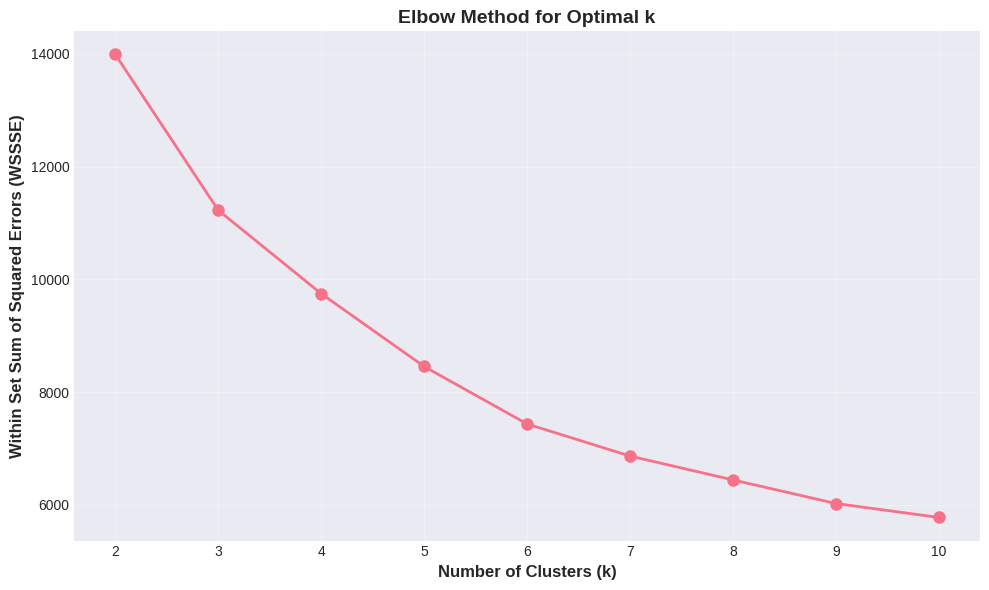

In [52]:
# Calculate Within Set Sum of Squared Errors (WSSSE) for different k values
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
wssse_values = []


for k in k_values:
    kmeans = KMeans(
        featuresCol="scaled_features",
        predictionCol="cluster",
        k=k,
        seed=42,
        maxIter=20
    )
    
    model = kmeans.fit(df_final)
    wssse = model.summary.trainingCost
    wssse_values.append(wssse)
    
    print(f"k={k}: WSSSE = {wssse:.2f}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, wssse_values, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)', fontsize=12, fontweight='bold')
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.tight_layout()
plt.show()



## Step 7: Apply K-Means Clustering

In [57]:
# Choose number of clusters
n_clusters = 5

# Create K-Means model
kmeans = KMeans(
    featuresCol="scaled_features",
    predictionCol="cluster",
    k=n_clusters,
    seed=42,
    maxIter=100
)

# Train the model
kmeans_model = kmeans.fit(df_final)

# Make predictions
df_clustered = kmeans_model.transform(df_final)

# Calculate WSSSE
wssse = kmeans_model.summary.trainingCost
print(f"\nK-Means model trained")
print(f"Within Set Sum of Squared Errors (WSSSE): {wssse:.2f}")

# Show cluster distribution
print("\nCluster distribution:")
df_clustered.groupBy("cluster").count().orderBy("cluster").show()



K-Means model trained
Within Set Sum of Squared Errors (WSSSE): 8453.15

Cluster distribution:
+-------+-----+
|cluster|count|
+-------+-----+
|      0|  656|
|      1| 1810|
|      2|  872|
|      3|  830|
|      4|  366|
+-------+-----+



## Step 8: Interpret and Characterize Clusters


CLUSTER INTERPRETATION

Cluster Summary (Average Values):
Cluster    Price ($)    Reviews         Peak CCU        Avg Playtime (h)   Median Playtime (h) 
----------------------------------------------------------------------------------------------------
0          $11.22       1,133           12              0.6                0.5                 
1          $10.85       1,655           12              3.9                4.0                 
2          $18.39       1,955           43              82.0               110.6               
3          $16.91       33,780          1,483           26.1               10.5                
4          $47.54       40,532          5,214           43.5               27.7                

CLUSTER DESCRIPTIONS

Cluster 0 (n=656):
  Average price: $11.22
  Average reviews: 1,133
  Average peak CCU: 12
  Average playtime: 0.6 hours
  Median playtime: 0.5 hours
  Interpretation: Games in this cluster exhibit very low playtime with minimal player retent

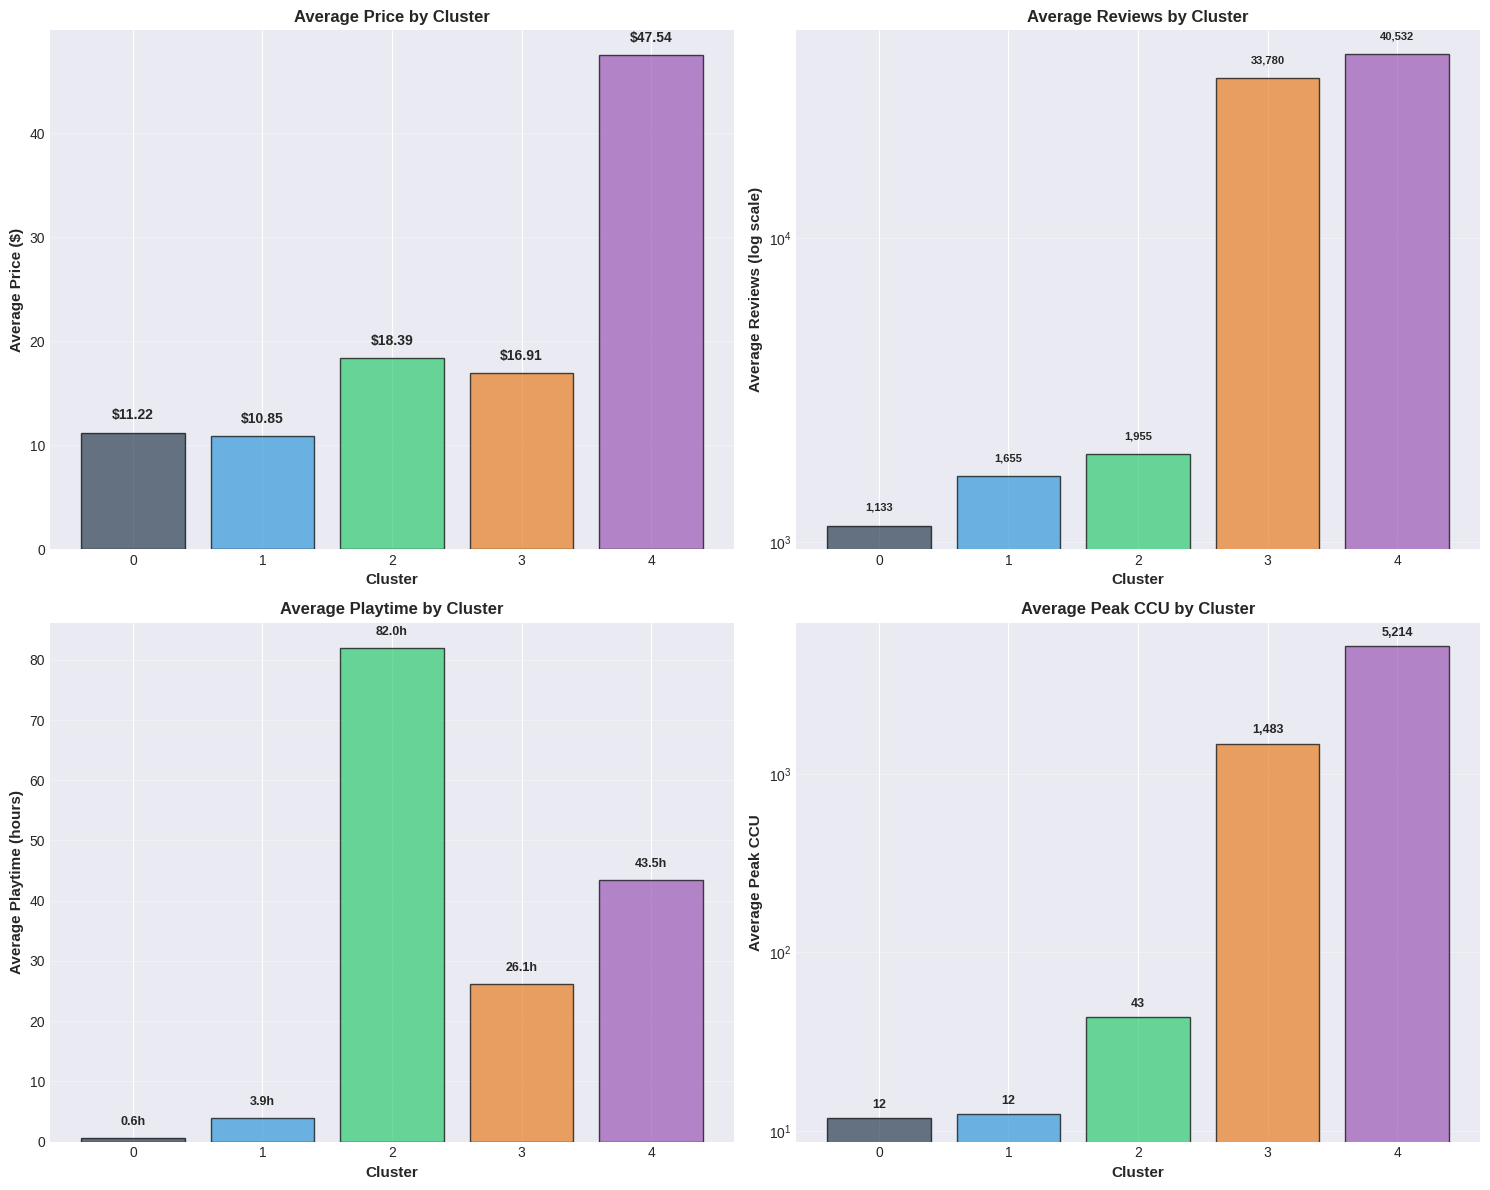


Use these comparisons to understand what makes each cluster unique!


In [ ]:
# Interpret and characterize clusters
print("CLUSTER INTERPRETATION")

# Calculate average values for each cluster
# Note: playtime values are stored in minutes, convert to hours for interpretation
from pyspark.sql.functions import avg

cluster_summary = df_clustered.groupBy("cluster").agg(
    avg("price").alias("avg_price"),
    avg("num_reviews_total").alias("avg_reviews"),
    avg("peak_ccu").alias("avg_peak_ccu"),
    avg("average_playtime_forever").alias("avg_playtime_minutes"),
    avg("median_playtime_forever").alias("avg_median_playtime_minutes")
).orderBy("cluster")

# Convert to pandas and convert playtime from minutes to hours
cluster_summary_pd = cluster_summary.toPandas()
cluster_summary_pd['avg_playtime_hours'] = cluster_summary_pd['avg_playtime_minutes'] / 60.0
cluster_summary_pd['avg_median_playtime_hours'] = cluster_summary_pd['avg_median_playtime_minutes'] / 60.0

# Display summary table with hours
print("\nCluster Summary (Average Values):")
print(f"{'Cluster':<10} {'Price ($)':<12} {'Reviews':<15} {'Peak CCU':<15} {'Avg Playtime (h)':<18} {'Median Playtime (h)':<20}")
print("-" * 100)
for idx, row in cluster_summary_pd.iterrows():
    cluster_id = int(row['cluster'])
    price = row['avg_price']
    reviews = row['avg_reviews']
    ccu = row['avg_peak_ccu']
    playtime_h = row['avg_playtime_hours']
    median_playtime_h = row['avg_median_playtime_hours']
    print(f"{cluster_id:<10} ${price:<11.2f} {reviews:<15,.0f} {ccu:<15,.0f} {playtime_h:<18.1f} {median_playtime_h:<20.1f}")

# Descriptive interpretation of each cluster
print("\n")
print("CLUSTER DESCRIPTIONS")

for idx, row in cluster_summary_pd.iterrows():
    cluster_id = int(row['cluster'])
    price = row['avg_price']
    reviews = row['avg_reviews']
    ccu = row['avg_peak_ccu']
    playtime_h = row['avg_playtime_hours']
    median_playtime_h = row['avg_median_playtime_hours']
    count = df_clustered.filter(col("cluster") == cluster_id).count()
    
    print(f"\nCluster {cluster_id} (n={count:,}):")
    print(f"  Average price: ${price:.2f}")
    print(f"  Average reviews: {reviews:,.0f}")
    print(f"  Average peak CCU: {ccu:,.0f}")
    print(f"  Average playtime: {playtime_h:.1f} hours")
    print(f"  Median playtime: {median_playtime_h:.1f} hours")
    
    # Descriptive interpretation based on provided guidance patterns
    if playtime_h < 1 and reviews < 2000:
        description = "Games in this cluster exhibit very low playtime with minimal player retention, combined with limited reach and small player base. This pattern suggests low-engagement or abandoned titles with minimal player retention."
    elif playtime_h >= 3 and playtime_h <= 5 and reviews < 2000:
        description = "Games in this cluster exhibit low to moderate playtime with some player commitment, combined with limited reach and small player base. This pattern suggests small-scale games with limited reach but some player commitment, such as short indie or narrative-driven titles."
    elif playtime_h > 80 and reviews < 5000:
        description = "Games in this cluster exhibit very high playtime with highly dedicated player base, combined with limited reach and small player base. This pattern suggests high-commitment niche games with a small but highly dedicated player base, often seen in simulation or complex strategy titles."
    elif reviews > 20000 and ccu > 1000 and playtime_h >= 20 and playtime_h <= 30:
        description = "Games in this cluster exhibit moderate playtime with moderate engagement, combined with broad popularity and large audiences and high concurrency. This pattern suggests mass-market popular games that attract large audiences and high concurrency, though individual play sessions may be shorter."
    elif price > 30 and reviews > 20000 and ccu > 1000 and playtime_h > 40:
        description = "Games in this cluster exhibit high playtime with sustained engagement, combined with broad popularity and large audiences and high concurrency, and premium pricing. This pattern suggests large-scale premium titles that combine broad popularity with sustained player engagement."
    else:
        # Generic description based on relative characteristics
        other_clusters = cluster_summary_pd[cluster_summary_pd['cluster'] != cluster_id]
        playtime_relative = "higher" if playtime_h > other_clusters['avg_playtime_hours'].mean() else "lower"
        reviews_relative = "higher" if reviews > other_clusters['avg_reviews'].mean() else "lower"
        ccu_relative = "higher" if ccu > other_clusters['avg_peak_ccu'].mean() else "lower"
        price_relative = "higher" if price > other_clusters['avg_price'].mean() else "lower"
        
        description = f"Games in this cluster exhibit {playtime_relative} average playtime, {reviews_relative} review volume, {ccu_relative} peak concurrency, and {price_relative} pricing compared to other clusters. This cluster represents games with a distinct combination of engagement depth, popularity, and pricing characteristics."
    
    print(f"  Interpretation: {description}")

# Create comparison visualization
print("\n")
print("CLUSTER COMPARISON VISUALIZATION")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Color palette for clusters (neutral, academic colors)
colors = ['#2c3e50', '#3498db', '#2ecc71', '#e67e22', '#9b59b6', '#1abc9c'][:n_clusters]

# 1. Average Price by Cluster
axes[0, 0].bar(cluster_summary_pd['cluster'], cluster_summary_pd['avg_price'], 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Average Price ($)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Average Price by Cluster', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, price in enumerate(cluster_summary_pd['avg_price']):
    axes[0, 0].text(i, price + 1, f'${price:.2f}', ha='center', va='bottom', fontweight='bold')

# 2. Average Reviews by Cluster (log scale)
axes[0, 1].bar(cluster_summary_pd['cluster'], cluster_summary_pd['avg_reviews'], 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Average Reviews (log scale)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Average Reviews by Cluster', fontsize=12, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, reviews in enumerate(cluster_summary_pd['avg_reviews']):
    axes[0, 1].text(i, reviews * 1.1, f'{reviews:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

# 3. Average Playtime by Cluster (in hours)
axes[1, 0].bar(cluster_summary_pd['cluster'], cluster_summary_pd['avg_playtime_hours'], 
               color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Average Playtime (hours)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Average Playtime by Cluster', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, playtime_h in enumerate(cluster_summary_pd['avg_playtime_hours']):
    offset = max(cluster_summary_pd['avg_playtime_hours']) * 0.02
    axes[1, 0].text(i, playtime_h + offset, f'{playtime_h:.1f}h', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Average Peak CCU by Cluster
axes[1, 1].bar(cluster_summary_pd['cluster'], cluster_summary_pd['avg_peak_ccu'], 
               color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Average Peak CCU', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Average Peak CCU by Cluster', fontsize=12, fontweight='bold')
axes[1, 1].set_yscale('log')  # Log scale for better visualization
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, ccu in enumerate(cluster_summary_pd['avg_peak_ccu']):
    axes[1, 1].text(i, ccu * 1.1, f'{ccu:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\nUse these comparisons to understand what makes each cluster unique!")


## Step 9: Visualize Clusters (Scatter Plots)


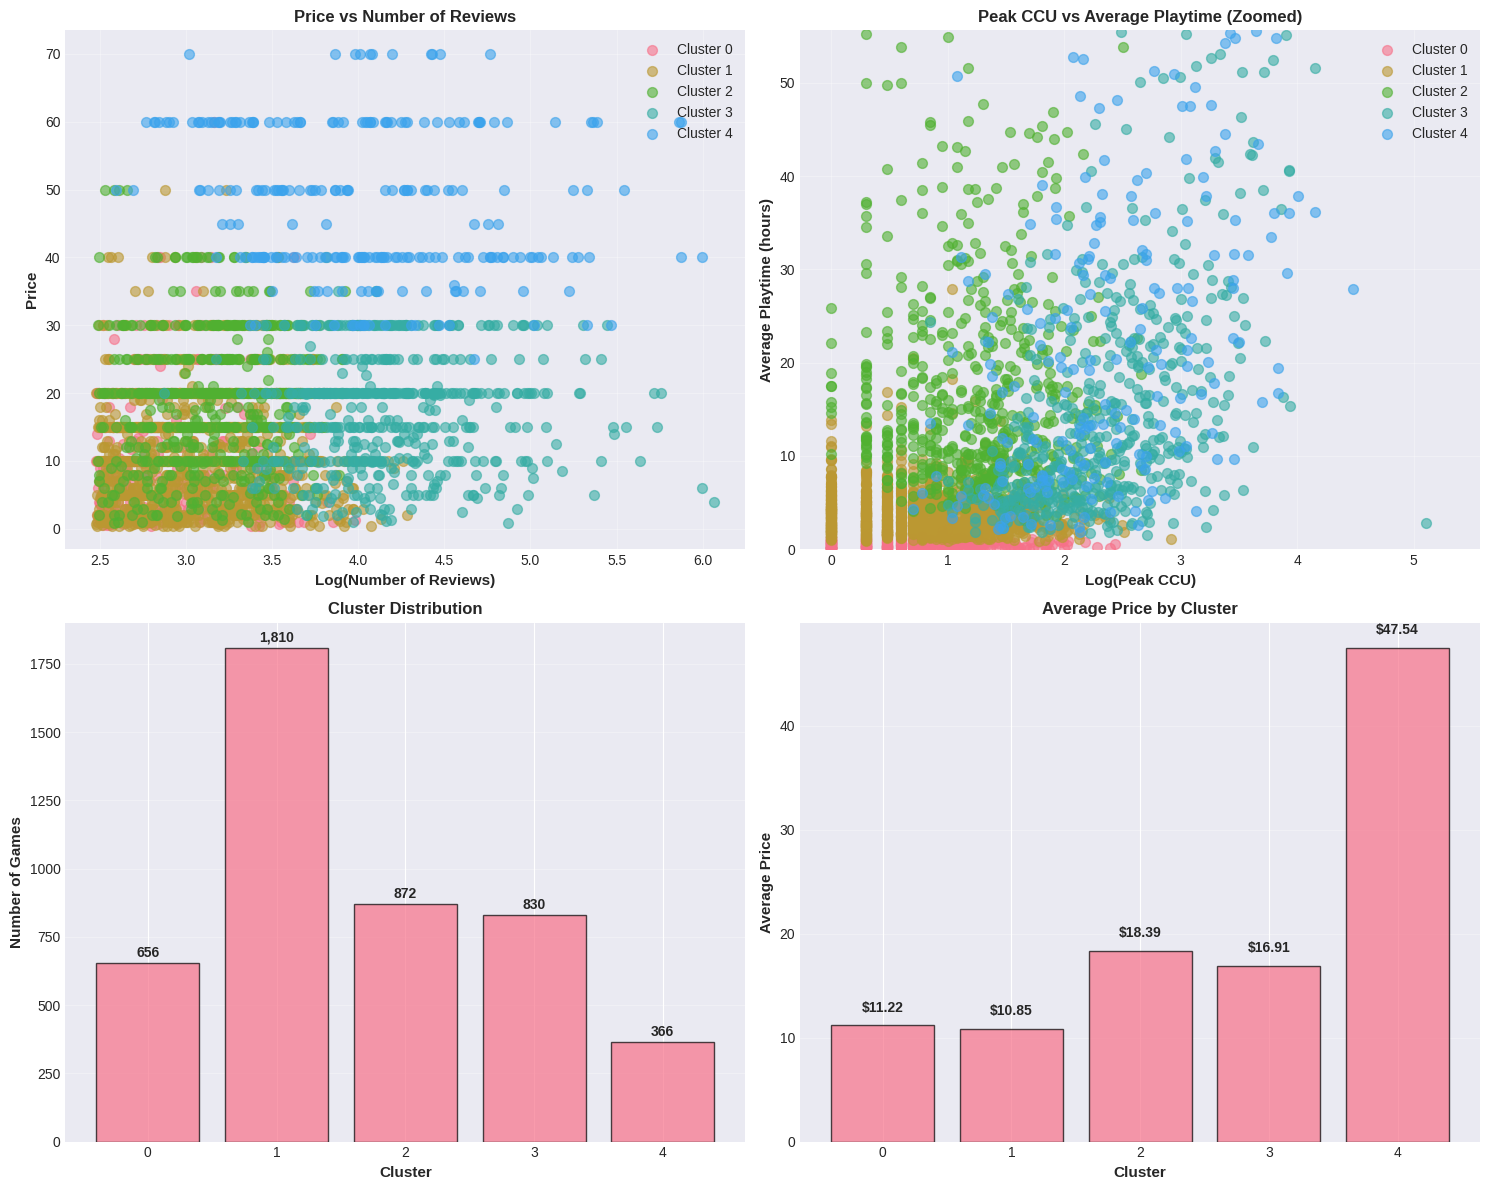

Plotted 3,000 games (sampled from 4,534 total)


In [61]:
# Sample data for visualization (too large to plot all)
sample_size = min(3000, df_clustered.count())
df_sample = df_clustered.sample(False, sample_size/df_clustered.count(), seed=42)

# Convert to pandas for plotting
# Note: Convert playtime from minutes to hours for visualization
df_plot = df_sample.select(
    'name', 'cluster', 'price', 'num_reviews_total', 'peak_ccu', 
    'average_playtime_forever', 'log_num_reviews_total', 'log_peak_ccu',
    'log_avg_playtime'
).toPandas()

# Convert playtime from minutes to hours
df_plot['average_playtime_hours'] = df_plot['average_playtime_forever'] / 60.0

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Price vs Reviews (log scale)
for cluster_id in range(n_clusters):
    cluster_data = df_plot[df_plot['cluster'] == cluster_id]
    axes[0, 0].scatter(
        cluster_data['log_num_reviews_total'], 
        cluster_data['price'],
        alpha=0.6, 
        label=f'Cluster {cluster_id}',
        s=50
    )
axes[0, 0].set_xlabel('Log(Number of Reviews)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Price', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Price vs Number of Reviews', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Peak CCU vs Average Playtime (log scale for CCU, linear for playtime in hours)
# Calculate y-axis limits to zoom in on the main data range (exclude extreme outliers)
playtime_values = df_plot['average_playtime_hours'].values
playtime_q95 = np.percentile(playtime_values, 95)  # 95th percentile
playtime_q5 = np.percentile(playtime_values, 5)    # 5th percentile
y_min = max(0, playtime_q5 - (playtime_q95 - playtime_q5) * 0.1)  # Add 10% padding below
y_max = playtime_q95 + (playtime_q95 - playtime_q5) * 0.1  # Add 10% padding above

for cluster_id in range(n_clusters):
    cluster_data = df_plot[df_plot['cluster'] == cluster_id]
    axes[0, 1].scatter(
        cluster_data['log_peak_ccu'], 
        cluster_data['average_playtime_hours'],
        alpha=0.6, 
        label=f'Cluster {cluster_id}',
        s=50
    )
axes[0, 1].set_xlabel('Log(Peak CCU)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Average Playtime (hours)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Peak CCU vs Average Playtime (Zoomed)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim(y_min, y_max)  # Zoom in on main data range
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Cluster distribution (bar chart)
cluster_counts = df_clustered.groupBy("cluster").count().orderBy("cluster").toPandas()
axes[1, 0].bar(cluster_counts['cluster'], cluster_counts['count'], alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Number of Games', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Cluster Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
# Add count labels
for i, count in enumerate(cluster_counts['count']):
    axes[1, 0].text(i, count + 10, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# 4. Average price by cluster
avg_price_by_cluster = df_clustered.groupBy("cluster").agg({"price": "mean"}).orderBy("cluster").toPandas()
axes[1, 1].bar(avg_price_by_cluster['cluster'], avg_price_by_cluster['avg(price)'], alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Average Price', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Average Price by Cluster', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
# Add value labels
for i, price in enumerate(avg_price_by_cluster['avg(price)']):
    axes[1, 1].text(i, price + 1, f'${price:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Plotted {sample_size:,} games (sampled from {df_clustered.count():,} total)")


## Step 10: Save Results


In [ ]:
# Save clustered results
output_path = "output/game_clusters_kmeans"

# Select columns to save
columns_to_save = [
    'appid', 'name', 'cluster', 'price',
    'average_playtime_forever', 'median_playtime_forever',
    'num_reviews_total', 'peak_ccu'
]

df_clustered.select(columns_to_save).write.mode("overwrite").option("header", "true").csv(output_path)


print(f"Clustered data saved to: {output_path}")
print(f"Total games clustered: {df_clustered.count():,}")
print(f"Number of clusters: {n_clusters}")


## Summary

### Clustering Task:
- **Algorithm**: K-Means (Spark ML)
- **Features**: Price, Average Playtime (minutes), Median Playtime (minutes), Number of Reviews, Peak CCU
- **Preprocessing**: Removed free games, removed games with zero engagement, applied log scaling, standardized features
- **Number of Clusters**: Determined via elbow method

### Key Findings:
- Clusters represent distinct engagement and popularity patterns
- Each cluster exhibits different relative characteristics in terms of price, reviews, playtime, and concurrency
- Clustering reveals natural groupings in game player behavior and market positioning


In [ ]:
spark.stop()

Spark session stopped.
